# Decoding Speed

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
decoder: str = "mwpm"
json_filename: str = "speed-rsc-mwpm.json"  # where to save the result, must be provided

rounds: int = 200
kwargs = dict(
    min_time = 60,
    min_shots = 50,
    min_init_time = 0.1,
    min_init_shots = 1,
)
max_per_round_time: float = 0.1  # if each round takes more than 100ms to decode, then do not run the next `d`, since it is not meaningful anymore

In [2]:
# Parameters
decoder = "bplsd"
json_filename = "speed-rsc-bplsd.json"


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# import psutil
# psutil.Process().nice(0)# if on *ux
# psutil.Process().nice(psutil.IDLE_PRIORITY_CLASS)# if on win

In [5]:
from qec_lego_bench.cli.decoding_speed import decoding_speed, DecodingSpeedResult
from qec_lego_bench.hpc.job_store import Job, JobStore
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import *

In [6]:
def generate_d_vec(ratio: float = 1.18, max_d: int = 51) -> list[int]:
    d = 3
    d_vec = [d]
    while d <= max_d:
        int_d = 2 * round(d / 2) + 1
        if int_d != d_vec[-1]:
            d_vec.append(int_d)
        d *= ratio
    return d_vec
d_vec = generate_d_vec()
print("d_vec:", d_vec)
p_vec = [0.00001, 0.0001, 0.001, 0.003, 0.01]

def evaluation_function(d: int, p: float, rounds: int, verbose: bool = True) -> DecodingSpeedResult:
    if verbose:
        print(f"d: {d}, p: {p}")
    return decoding_speed(decoder=decoder, code=f"rsc(d={d},p={p})", **kwargs, no_print=not verbose)

jobs = [Job(d=d, p=p, rounds=rounds) for p in p_vec for d in d_vec[:1]]  # only add the smallest d and dynamically add others
evaluation_function(min(d_vec), min(p_vec), rounds)

d_vec: [3, 5, 7, 9, 11, 13, 15, 17, 19, 23, 27, 31, 37, 43, 51]
d: 3, p: 1e-05



initialization time: 2.752e-03s



decoding time: 1.859e-05s


DecodingSpeedResult(elapsed=66.25061327777075, shots=3563452)

Define the plot functionality

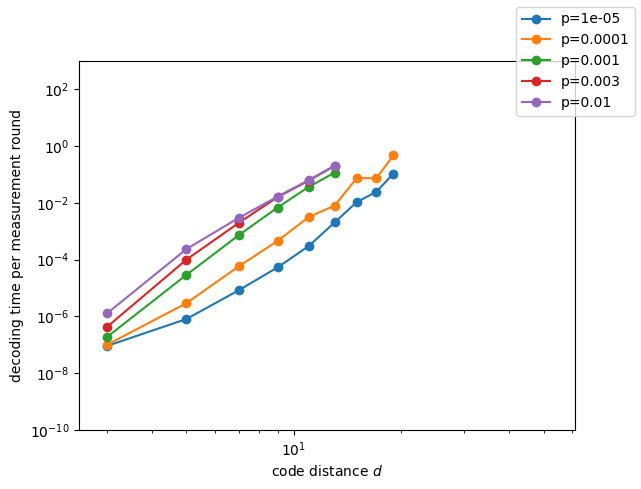

In [7]:
@dataclass
class DecodingTimePlotter:
    hdisplay: display.DisplayHandle = field(
        default_factory=lambda: display.display("", display_id=True)
    )

    def __call__(self, executor: MonteCarloJobExecutor):
        # add more d if the previous one is not too slow
        for p in p_vec:
            for d_idx, d in enumerate(d_vec[:-1]):
                job = executor.get_job(d=d, p=p, rounds=rounds)
                if job is None or job.result is None:
                    continue
                per_round_time = job.result.decoding_time / rounds
                if per_round_time > max_per_round_time:
                    break
                next_d = d_vec[d_idx + 1]
                next_job = executor.get_job(d=next_d, p=p, rounds=rounds)
                if next_job is None:
                    executor.add_job(Job(d=next_d, p=p, rounds=rounds))

        # plot the results
        fig, ax = plt.subplots(1, 1)
        ax.clear()
        ax.set_xlabel("code distance $d$")
        ax.set_ylabel("decoding time per measurement round")
        ax.set_xlim(min(d_vec) / 1.2, max(d_vec) * 1.2)
        ax.set_xscale("log")
        ax.set_ylim(1e-10, 1e3)
        ax.set_yscale("log")
        for p in p_vec:
            x_vec = []
            y_vec = []
            for d in d_vec:
                job = executor.get_job(d=d, p=p, rounds=rounds)
                if job is None or job.result is None:
                    continue
                x_vec.append(d)
                y_vec.append(job.result.decoding_time / rounds)
            ax.errorbar(x_vec, y_vec, label=f"p={p}", fmt="o-")
        fig.legend()
        self.hdisplay.update(fig)
        plt.close(fig)

plotter = DecodingTimePlotter()

In [8]:
job_store = JobStore(evaluation_function, jobs, result_type=DecodingSpeedResult, filename=json_filename)
job_store.execute(loop_callback=plotter)